In [1]:
#Prepare data
from time import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm_notebook
from sklearn.preprocessing import LabelEncoder, StandardScaler

#Building model
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

#other
import warnings
warnings.filterwarnings('ignore')

## 1. Data Preparation

In [2]:
%%time

cols = ["PSTV01","PSTV02","PSTV15","FKP02","FKP03","FKP04","FKP05","FKP06",
        "FKP07","FKP08","FKP09","FKP10","FKP11","FKP12","FKP14","FKP14A",
        "FKP15","FKP15A","FKP16","FKP17","FKP18","FKP19","FKP20","FKP21",
        "FKP22","FKP13Class"]

ori_data = pd.read_csv("train_fktp.txt", names=cols)
test_data = pd.read_csv("test_fktp.txt", names=cols[:-1])

target_col = "FKP02"
test_data_ids = test_data[target_col]

pd.set_option('display.max_columns', None)
train_data = ori_data.copy()

CPU times: total: 20.1 s
Wall time: 20.3 s


In [3]:
ori_data.head()

,PSTV01,PSTV02,PSTV15,FKP02,FKP03,FKP04,FKP05,FKP06,FKP07,FKP08,FKP09,FKP10,FKP11,FKP12,FKP14,FKP14A,FKP15,FKP15A,FKP16,FKP17,FKP18,FKP19,FKP20,FKP21,FKP22,FKP13Class
0,157978748.0,50765420,20.064983,958073632,2019-08-01,2019-08-01,61,6108,3,1,4,1,12.0,2,9999,NaN,9999,9999,98,9998,98,98,98,98,2,Sehat
1,95085112.0,26931775,2.626307,449590620P000054,2020-06-17,2020-06-17,51,5171,9,3,2,1,1.0,4,773,K29,K297,"Gastritis, unspecified",98,9998,98,98,98,98,1,Belum_Sehat
2,224470578.0,227368233,1.051830,467490619P000001,2019-06-01,2019-06-01,35,3516,9,2,1,1,3.0,4,1757,Z30,Z309,"Contraceptive management, unspecified",98,9998,98,98,98,98,1,Belum_Sehat
3,63871289.0,62313678,364.741455,254321219Y002368,2019-12-21,2019-12-21,34,3402,3,1,4,1,1.0,5,621,I10,I10,Essential (primary) hypertension,98,9998,98,98,98,98,1,Belum_Sehat
4,29915626.0,113446188,1.050523,88681119P000020,2019-11-04,2019-11-04,35,3509,3,1,4,1,1.0,1,622,I11,I110,Hypertensive heart disease with (congestive) h...,98,9998,98,98,98,98,1,Belum_Sehat


In [4]:
train_data.isna().sum()

PSTV01              0
PSTV02              0
PSTV15              0
FKP02               0
FKP03               0
FKP04               0
FKP05               0
FKP06               0
FKP07               0
FKP08               0
FKP09               0
FKP10               0
FKP11               1
FKP12               0
FKP14               0
FKP14A        1380241
FKP15               0
FKP15A              0
FKP16               0
FKP17               0
FKP18               0
FKP19               0
FKP20               0
FKP21               0
FKP22               0
FKP13Class          0
dtype: int64

In [5]:
test_data.isna().sum()

PSTV01         0
PSTV02         0
PSTV15         0
FKP02          0
FKP03          0
FKP04          0
FKP05          0
FKP06          0
FKP07          0
FKP08          0
FKP09          0
FKP10          0
FKP11          0
FKP12          0
FKP14          0
FKP14A    345912
FKP15          0
FKP15A         0
FKP16          0
FKP17          0
FKP18          0
FKP19          0
FKP20          0
FKP21          0
FKP22          0
dtype: int64

## 2. Data Cleaning

In [6]:
def clean(df, option=0):
    if option:
        df["label"] = df.FKP13Class.map(dict(Sehat=1, Belum_Sehat=0))

    df = df.drop(["PSTV01", "PSTV02", "FKP02"], axis=1)
    return df

In [7]:
train_clean_data = clean(train_data, 1)
test_clean_data = clean(test_data)
all_clean_data = pd.concat([train_clean_data, test_clean_data])

In [8]:
train_clean_data.head()

,PSTV15,FKP03,FKP04,FKP05,FKP06,FKP07,FKP08,FKP09,FKP10,FKP11,FKP12,FKP14,FKP14A,FKP15,FKP15A,FKP16,FKP17,FKP18,FKP19,FKP20,FKP21,FKP22,FKP13Class,label
0,20.064983,2019-08-01,2019-08-01,61,6108,3,1,4,1,12.0,2,9999,NaN,9999,9999,98,9998,98,98,98,98,2,Sehat,1
1,2.626307,2020-06-17,2020-06-17,51,5171,9,3,2,1,1.0,4,773,K29,K297,"Gastritis, unspecified",98,9998,98,98,98,98,1,Belum_Sehat,0
2,1.051830,2019-06-01,2019-06-01,35,3516,9,2,1,1,3.0,4,1757,Z30,Z309,"Contraceptive management, unspecified",98,9998,98,98,98,98,1,Belum_Sehat,0
3,364.741455,2019-12-21,2019-12-21,34,3402,3,1,4,1,1.0,5,621,I10,I10,Essential (primary) hypertension,98,9998,98,98,98,98,1,Belum_Sehat,0
4,1.050523,2019-11-04,2019-11-04,35,3509,3,1,4,1,1.0,1,622,I11,I110,Hypertensive heart disease with (congestive) h...,98,9998,98,98,98,98,1,Belum_Sehat,0


## 3. Exploratory Data Analysis

In [9]:
label_1 = train_data.label.sum() / train_data.shape[0]
label_0 = 1 - label_1

print(f"label 0 : {label_0*100:.2f}%")
print(f"label 1 : {label_1*100:.2f}%")

label 0 : 64.94%
label 1 : 35.06%


<AxesSubplot:>

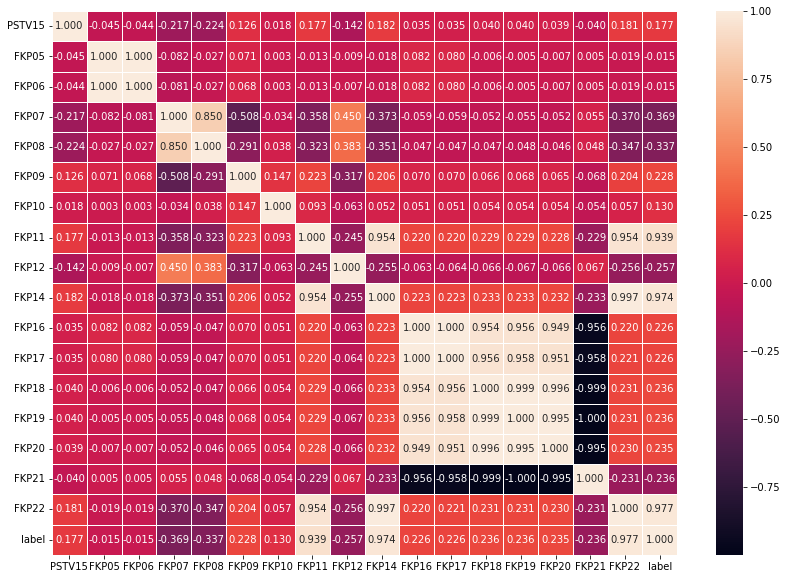

In [10]:
f,ax = plt.subplots(figsize=(14, 10))
sns.heatmap(train_clean_data.corr(), annot=True, linewidths=.5, fmt=".3f", ax=ax)

In [11]:
def hist_plot(df, col, target="label"):
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
    bins = 50

    ax1.hist(df[col][df[target] == 1], bins=bins)
    ax1.set_title("Sehat")

    ax2.hist(df[col][df[target] == 0], bins=bins)
    ax2.set_title("Belum Sehat")
    plt.show()

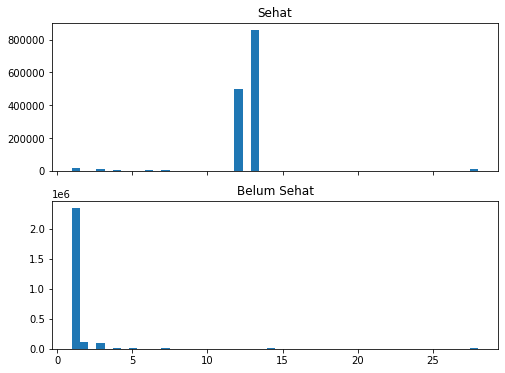

In [12]:
hist_plot(train_clean_data, "FKP11")

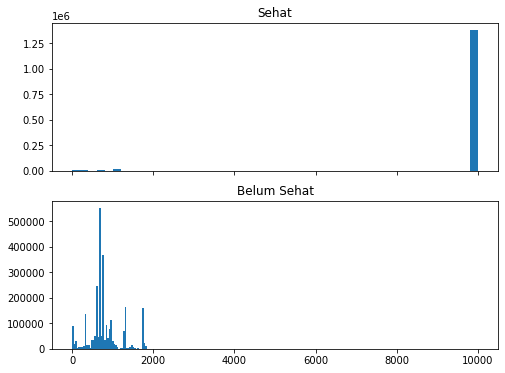

In [13]:
hist_plot(train_clean_data, "FKP14")

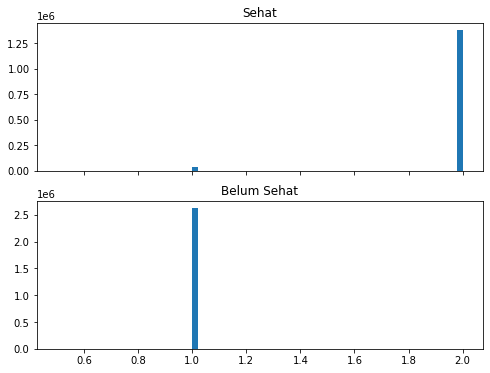

In [14]:
hist_plot(train_clean_data, "FKP22")

## 4. Feature Engineering and Preprocessing

In [15]:
def engineering(df):
    df["FKP03"] = pd.to_datetime(df["FKP03"])
    df["FKP04"] = pd.to_datetime(df["FKP04"])
    df["lamainap"] = (df["FKP04"]-df["FKP03"]).dt.days
    df["tahun"] = df["FKP03"].dt.year
    df["kuarter"] = df["FKP03"].dt.quarter
    df["bulan"] = df["FKP03"].dt.month
    df["harike"] = df["FKP03"].dt.dayofweek

    df["diag_icd_0"] = df["FKP14A"].str[0]
    df["diag_icd_1"] = df["FKP14A"].str[1:]
    df["diag_icd_2"] = df["FKP15"].apply(lambda x: str(x)[-1] if str(x) != "9999" else str(x))

    df["diag_icd_0"].fillna("9999", inplace=True)
    df["diag_icd_1"].fillna("9999", inplace=True)
    df["FKP11"].fillna(df["FKP11"].mode()[0], inplace=True)

    df = df.drop(["FKP03", "FKP04","FKP14A", "FKP15", "FKP05", "FKP06", "FKP15A"], axis=1)

    return df

def label_encode(df):
    obj_cols = list(df.select_dtypes(include="object").columns)
    le = LabelEncoder()
    for col in obj_cols:
        df[col] = df[col].astype(str)
        df[col] = le.fit_transform(df[col])
    
    return df

def split_data(df, train_data):
    return df.iloc[:train_data.shape[0],:], df.iloc[train_data.shape[0]:,:]

In [16]:
%%time

all_data = engineering(all_clean_data)
all_encode_data = label_encode(all_data)

CPU times: total: 16.6 s
Wall time: 16.7 s


In [17]:
train_data, test_data = split_data(all_encode_data, train_data)
test_data = test_data.drop(["FKP13Class", "label"], axis=1)

train_data.head()

,PSTV15,FKP07,FKP08,FKP09,FKP10,FKP11,FKP12,FKP14,FKP16,FKP17,FKP18,FKP19,FKP20,FKP21,FKP22,FKP13Class,label,lamainap,tahun,kuarter,bulan,harike,diag_icd_0,diag_icd_1,diag_icd_2
0,20.064983,3,1,4,1,12.0,2,9999,98,9998,98,98,98,98,2,1,1.0,0,2019,3,8,3,0,100,10
1,2.626307,9,3,2,1,1.0,4,773,98,9998,98,98,98,98,1,0,0.0,0,2020,2,6,2,11,29,7
2,1.051830,9,2,1,1,3.0,4,1757,98,9998,98,98,98,98,1,0,0.0,0,2019,2,6,5,26,30,9
3,364.741455,3,1,4,1,1.0,5,621,98,9998,98,98,98,98,1,0,0.0,0,2019,4,12,5,9,10,0
4,1.050523,3,1,4,1,1.0,1,622,98,9998,98,98,98,98,1,0,0.0,0,2019,4,11,0,9,11,0


## 5. Modelling

In [18]:
def get_stratified_data(data, idx=0, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    target = data.loc[:, "label"]
    train_idx, val_idx = list(skf.split(data, target))[idx]

    X_train = data.loc[train_idx,:].drop(["FKP13Class", "label"], axis=1)
    X_val = data.loc[val_idx,:].drop(["FKP13Class", "label"], axis=1)
    y_train = data.loc[train_idx,:].label
    y_val = data.loc[val_idx,:].label

    return X_train, X_val, y_train, y_val

def evaluate(actual, predicted, show=2):
    cf_matrix = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = cf_matrix.ravel()
    recall = tp / (fn+tp)
    precision = tp / (fp+tp)
    scoref1 = f1_score(actual, predicted)
    
    if show:
        if show > 1:
            print(f"recall: {recall*100:.4f}%")
            print(f"precision: {precision*100:.4f}%")
        if show > 0:
            print(f"f1 score: {scoref1*100:.4f}%\n")
    else:
        return recall, precision, scoref1

def train_model(estimators, df):
    models_trained = []
    X_train, X_val, y_train, y_val = get_stratified_data(df)

    for num, model in tqdm_notebook(enumerate(estimators)):
        start = time()

        base_model = model.fit(X_train, y_train)
        pred_val = base_model.predict(X_val)
        print(f"{num + 1}. {str(model).split('(')[0]} - {time() - start}")
        evaluate(y_val, pred_val)

        models_trained.append(model)
    
    return models_trained

In [19]:
%%time

estimators = [RandomForestClassifier(random_state=42), 
              LGBMClassifier(), XGBClassifier()]

train_model(estimators=estimators, df=train_data)

0it [00:00, ?it/s]

1. RandomForestClassifier - 414.40823340415955
recall: 99.9174%
precision: 99.8781%
f1 score: 99.8977%

2. LGBMClassifier - 20.946927070617676
recall: 99.9279%
precision: 99.8602%
f1 score: 99.8941%

3. XGBClassifier - 297.6614034175873
recall: 99.9315%
precision: 99.8714%
f1 score: 99.9014%

CPU times: total: 26min 54s
Wall time: 12min 19s


[RandomForestClassifier(random_state=42),
 LGBMClassifier(),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
               reg_alpha=0, reg_lambda=1, ...)]

In [20]:
estimators_2 = [RandomForestClassifier(random_state=42, max_features=10, oob_score = True,n_jobs = -1, min_samples_leaf=5), 
                LGBMClassifier(learning_rate=0.04, n_estimators=800, max_depth=15, num_leaves=256),
                XGBClassifier(learning_rate=0.04, n_estimators=800, max_depth=15, num_leaves=256)]

train_model(estimators=estimators_2, df=train_data)

0it [00:00, ?it/s]

1. RandomForestClassifier - 305.23833107948303
recall: 99.9265%
precision: 99.8679%
f1 score: 99.8972%

2. LGBMClassifier - 177.650737285614
recall: 99.9350%
precision: 99.8900%
f1 score: 99.9125%

[01:41:09] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_leaves" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


3. XGBClassifier - 5783.902545928955
recall: 99.9360%
precision: 99.8960%
f1 score: 99.9160%



[RandomForestClassifier(max_features=10, min_samples_leaf=5, n_jobs=-1,
                        oob_score=True, random_state=42),
 LGBMClassifier(learning_rate=0.04, max_depth=15, n_estimators=800,
                num_leaves=256),
 XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='',
               learning_rate=0.04, max_bin=256, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=1,
               missing=nan, monotone_constraints='()', n_estimators=800,
               n_jobs=0, num_leaves=256, num_parallel_tree=1, predictor='auto',
               random_state=0, reg_alpha=0, ...)]

## 6. Evaluating

In [21]:
%%time

X_train, X_val, y_train, y_val = get_stratified_data(train_data)
eval_set = [(X_val, y_val), (X_train, y_train)]

lgbm = LGBMClassifier(learning_rate=0.04, n_estimators=800, max_depth=15, num_leaves=256)
lgbm.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=40, verbose=10)

[10]	training's binary_logloss: 0.371713	valid_0's binary_logloss: 0.371748
[20]	training's binary_logloss: 0.230633	valid_0's binary_logloss: 0.230698
[30]	training's binary_logloss: 0.148112	valid_0's binary_logloss: 0.148212
[40]	training's binary_logloss: 0.0970077	valid_0's binary_logloss: 0.097139
[50]	training's binary_logloss: 0.0643794	valid_0's binary_logloss: 0.0645448
[60]	training's binary_logloss: 0.0431683	valid_0's binary_logloss: 0.043373
[70]	training's binary_logloss: 0.0292321	valid_0's binary_logloss: 0.0294705
[80]	training's binary_logloss: 0.0199997	valid_0's binary_logloss: 0.0202805
[90]	training's binary_logloss: 0.0138478	valid_0's binary_logloss: 0.0141728
[100]	training's binary_logloss: 0.00973448	valid_0's binary_logloss: 0.0101034
[110]	training's binary_logloss: 0.00697606	valid_0's binary_logloss: 0.00738678
[120]	training's binary_logloss: 0.00511187	valid_0's binary_logloss: 0.00556726
[130]	training's binary_logloss: 0.00384645	valid_0's binary_log

LGBMClassifier(learning_rate=0.04, max_depth=15, n_estimators=800,
               num_leaves=256)

In [22]:
y_pred = lgbm.predict(X_val)
evaluate(y_val, y_pred)

recall: 99.9325%
precision: 99.8876%
f1 score: 99.9100%



<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

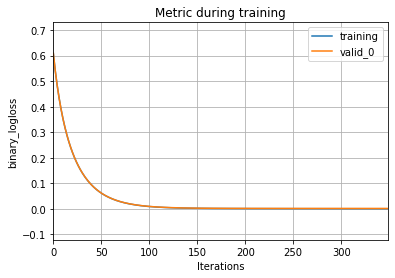

In [23]:
lgb.plot_metric(lgbm)

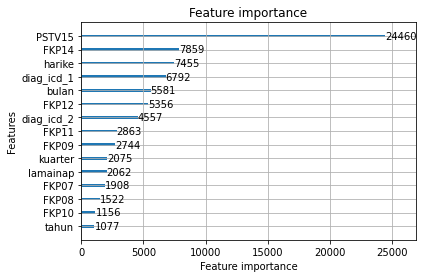

In [24]:
ax = lgb.plot_importance(lgbm, max_num_features=15)
plt.show()

## 7. Submission

In [25]:
test_pred = lgbm.predict(test_data)
test_pred

array([1., 1., 1., ..., 0., 0., 0.])

In [26]:
form_submit = pd.read_csv("form_submission.csv")
form_submit["Status"] = test_pred

form_submit["Unnamed: 0"] = form_submit["Unnamed: 0"].astype(str)
form_submit["FKP02"] = form_submit["FKP02"].astype(str)
form_submit["Status"] = form_submit["Status"].astype(int)
form_submit

,Unnamed: 0,FKP02,Status
0,1,954386050,1
1,2,774246805,1
2,3,1202010273,1
3,4,1286640248,1
4,5,1285179242,1
...,...,...,...
1014220,1014221,248870919P000406,0
1014221,1014222,116000620P000034,0
1014222,1014223,160421019P000631,0
1014223,1014224,332670919P000083,0


In [27]:
form_submit.to_csv("submission.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

Leaderboard score : 99.9071%